## Note on `git` and `ws3` embedded as submodule.

I am tracking this notebook-based project on GitHub, and have embedded the ws3 as a submodule. The following code pulls ws3 code from the cloud.

In [1]:
!git submodule init
!git submodule update

Submodule 'ws3' (https://github.com/gparadis/ws3) registered for path 'ws3'
Cloning into '/workspaces/model_prototype_0/ws3'...
Submodule path 'ws3': checked out '00b76880aa16109b81ccbd236c9c03726b888381'


The following is a hack to force this notebook to use the local `ws3` submodule code.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('ws3'))
if module_path not in sys.path:
    sys.path.append(module_path)
#sys.path

## Preamble

Import modules, define classes and functions and constants, etc.

In [3]:
%load_ext autoreload
%autoreload 2

In [9]:
%pip install rasterio
%pip install fiona
%pip install gurobipy


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 65.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import ws3.forest, ws3.core
import gurobipy as grb

import matplotlib.pyplot as plt
import pandas as pd

In [11]:
data_path = 'data/input'
period_length = 10
max_age = 500
base_year = 2020
horizon = 10
model_name = 'tsa24_clipped'
harvest_acode = 'cc'

# Create a new `ForestModel` instance

In [12]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [13]:
fm.import_landscape_section()

In [14]:
fm.import_areas_section()

0

In [15]:
fm.import_yields_section()

Note that we have to manually flag the `cc` action as a harvest action (or it will not pass the `is_harvest` gate in `cmp_c_z` when building the optimization model (and there will be no harvest volume to optimize, etc). Currently no way to do this automatically in the `import_actions_section` method, but will try to include something later to avoid having to remember to do this. 

In [16]:
fm.import_actions_section()
fm.actions[harvest_acode].is_harvest = True

Add a "null" action (does nothing). Needed for optimization functions to work. Sort of an obscure design, but that is the way ws3 is implemented for the moment so just roll with it.

In [17]:
fm.add_null_action()

In [18]:
fm.import_transitions_section()

In [19]:
fm.compile_actions()

In [20]:
fm.initialize_areas()
fm.reset_actions()

# Define scenario (add optimization problems)

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [21]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [22]:
def gen_scenario(fm, name='base', util=0.85, harvest_acode='cc', fert_acodes=[],
                 cflw_ha={}, cflw_hv={}, 
                 cgen_gs={}, cgen_ha={}, cgen_hv={}, cgen_fa={},
                 tvy_name='volume', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] + fert_acodes # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) # define objective function coefficient function  
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_fa: # define general constraint (fertilized area)
        cname = 'cgen_fa'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=fert_acodes, mask=None) 
        cgen_data[cname] = cgen_fa
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

Define functions to compile scenario output into a dataframe, and plot this data.

In [23]:
def compile_scenario(fm):
    oha = [fm.compile_product(period, '1.', acode='cc') for period in fm.periods]
    ohv = [fm.compile_product(period, 'volume * 0.85', acode='cc') for period in fm.periods]
    ogs = [fm.inventory(period, 'volume') for period in fm.periods]
    ofa11 = [fm.compile_product(period, '1.', acode='f11') for period in fm.periods] 
    ofa12 = [fm.compile_product(period, '1.', acode='f12') for period in fm.periods] 
    ofa13 = [fm.compile_product(period, '1.', acode='f13') for period in fm.periods] 
    ofa14 = [fm.compile_product(period, '1.', acode='f14') for period in fm.periods] 
    ofa15 = [fm.compile_product(period, '1.', acode='f15') for period in fm.periods] 
    ofa16 = [fm.compile_product(period, '1.', acode='f16') for period in fm.periods] 
    ofa17 = [fm.compile_product(period, '1.', acode='f17') for period in fm.periods] 
    ofa21 = [fm.compile_product(period, '1.', acode='f21') for period in fm.periods] 
    ofa22 = [fm.compile_product(period, '1.', acode='f22') for period in fm.periods] 
    ofa23 = [fm.compile_product(period, '1.', acode='f23') for period in fm.periods] 
    ofa24 = [fm.compile_product(period, '1.', acode='f24') for period in fm.periods] 
    ofa25 = [fm.compile_product(period, '1.', acode='f25') for period in fm.periods] 
    ofa26 = [fm.compile_product(period, '1.', acode='f26') for period in fm.periods] 
    ofa31 = [fm.compile_product(period, '1.', acode='f31') for period in fm.periods] 
    ofa32 = [fm.compile_product(period, '1.', acode='f32') for period in fm.periods] 
    ofa33 = [fm.compile_product(period, '1.', acode='f33') for period in fm.periods] 
    ofa34 = [fm.compile_product(period, '1.', acode='f34') for period in fm.periods] 
    ofa35 = [fm.compile_product(period, '1.', acode='f35') for period in fm.periods]
    data = {'period':fm.periods, 
            'oha':oha, 
            'ohv':ohv, 
            'ogs':ogs, 
            'ofa11':ofa11, 
            'ofa12':ofa12, 
            'ofa13':ofa13, 
            'ofa14':ofa14, 
            'ofa15':ofa15, 
            'ofa16':ofa16, 
            'ofa17':ofa17, 
            'ofa21':ofa21, 
            'ofa22':ofa22, 
            'ofa23':ofa23, 
            'ofa24':ofa24, 
            'ofa25':ofa25, 
            'ofa26':ofa26, 
            'ofa31':ofa31, 
            'ofa32':ofa32, 
            'ofa33':ofa33, 
            'ofa34':ofa34, 
            'ofa35':ofa35}
    df = pd.DataFrame(data)
    return df

In [24]:
def plot_scenario(df):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].bar(df.period, df.oha)
    ax[0].set_ylim(0, None)
    ax[0].set_title('Harvested area (ha)')
    ax[1].bar(df.period, df.ohv)
    ax[1].set_ylim(0, None)
    ax[1].set_title('Harvested volume (m3)')
    ax[2].bar(df.period, df.ogs)
    ax[2].set_ylim(0, None)
    ax[2].set_title('Growing Stock (m3)')
    ax[3].bar(df.period, df.ofa11)
    ax[3].bar(df.period, df.ofa12)
    ax[3].bar(df.period, df.ofa13)
    ax[3].bar(df.period, df.ofa14)
    ax[3].bar(df.period, df.ofa15)
    ax[3].bar(df.period, df.ofa16)
    ax[3].bar(df.period, df.ofa17)
    ax[3].bar(df.period, df.ofa21)
    ax[3].bar(df.period, df.ofa22)
    ax[3].bar(df.period, df.ofa23)
    ax[3].bar(df.period, df.ofa24)
    ax[3].bar(df.period, df.ofa25)
    ax[3].bar(df.period, df.ofa26)
    ax[3].bar(df.period, df.ofa31)
    ax[3].bar(df.period, df.ofa32)
    ax[3].bar(df.period, df.ofa33)
    ax[3].bar(df.period, df.ofa34)
    ax[3].bar(df.period, df.ofa35)
    #ax[3].legend(fert_acodes)
    ax[3].set_ylim(0, None)
    ax[3].set_title('Fertilized Area (ha)')
    return fig, ax

## Run scenarios

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

In [25]:
scenario_name = 'base'
#scenario_name = 'fert_once'
#scenario_name = 'fert_twice'
#scenario_name = 'fert_thrice'
#scenario_name = 'fert_age10'
#scenario_name = 'fert_age20'
#scenario_name = 'fert_age30'
#scenario_name = 'fert_age40'
#scenario_name = 'fert_age50'
#scenario_name = 'fert_age60'
#scenario_name = 'fert_age70'


In [26]:
cflw_ha = {}
cflw_hv = {}
cgen_gs = {}
cgen_ha = {}
cgen_hv = {}
cgen_fa = {}
fert_acodes = []

# define growing stock general constraints
#cgen_gs = {'lb':{9:35000.}, 'ub':{9:35001.}}    
#cgen_gs = {'lb':{p:20000. for p in fm.periods}, 'ub':{p:1000000. for p in fm.periods}}    

# define harvest area and harvest volume flow constraints
cflw_ha = ({p:0.05 for p in fm.periods}, 1)
cflw_hv = ({p:0.05 for p in fm.periods}, 1)

# define harvest area and harvest volume general constraints
#cgen_ha = {'lb':{1:10.}, 'ub':{1:11.}}    
#cgen_hv = {'lb':{1:20000.}, 'ub':{1:20001.}}    

# define fertilized area general constraints
#cgen_fa = {'lb':None, 'ub':{p:10. for p in fm.periods}}    


if scenario_name == 'base': 
    # Base scenario
    fert_acodes = []
elif scenario_name == 'fert_once': 
    # Base scenario, plus one-application fertilization actions
    fert_acodes=['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
elif scenario_name == 'fert_twice': 
    # Base scenario, plus two-application fertilization actions
    fert_acodes=['f21', 'f22', 'f23', 'f24', 'f25', 'f26']
elif scenario_name == 'fert_thrice': 
    # Base scenario, plus three-application fertilization actions
    fert_acodes=['f31', 'f32', 'f33', 'f34', 'f35']
elif scenario_name == 'fert_age10': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f11', 'f21', 'f31']
elif scenario_name == 'fert_age20': 
    # Base scenario, plus age-20 fertilization actions
    fert_acodes=['f12', 'f22', 'f32']
elif scenario_name == 'fert_age30': 
    # Base scenario, plus age-30 fertilization actions
    fert_acodes=['f13', 'f23', 'f33']
elif scenario_name == 'fert_age40': 
    # Base scenario, plus age-40 fertilization actions
    fert_acodes=['f14', 'f24', 'f34']
elif scenario_name == 'fert_age50': 
    # Base scenario, plus age-50 fertilization actions
    fert_acodes=['f15', 'f25', 'f35']
elif scenario_name == 'fert_age60': 
    # Base scenario, plus age-60 fertilization actions
    fert_acodes=['f16', 'f26']
elif scenario_name == 'fert_age70': 
    # Base scenario, plus age-70 fertilization actions
    fert_acodes=['f17']
    
p = gen_scenario(fm=fm, 
                 name=scenario_name, 
                 fert_acodes=fert_acodes, 
                 cflw_ha=cflw_ha, 
                 cflw_hv=cflw_hv,
                 cgen_gs=cgen_gs,
                 cgen_ha=cgen_ha,
                 cgen_hv=cgen_hv,
                 cgen_fa=cgen_fa)


You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (I usually install Gurobi in `/opt/gurobi` when setting up my development VMs).   

In [28]:
fm.reset()

Solve the optimization problem. Note that we stash a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

In [29]:
m = p.solve()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 64 rows, 297 columns and 3417 nonzeros
Model fingerprint: 0xf8d14f89
Coefficient statistics:
  Matrix range     [3e-02, 6e+04]
  Objective range  [4e+01, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 24 columns
Presolve time: 0.01s
Presolved: 60 rows, 273 columns, 3177 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3053602e+05   1.168626e+04   0.000000e+00      0s
      82    2.7971964e+05   0.000000e+00   0.000000e+00      0s

Solved in 82 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.797196356e+05
foo


If the model solved to optimality, simulate the optimal solution.

In [30]:
if m.status != grb.GRB.OPTIMAL:
    print('Model not optimal.')
    sys.exit()
sch = fm.compile_schedule(p)
fm.apply_schedule(sch, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

In [31]:
df = compile_scenario(fm)
df

,period,oha,ohv,ogs,ofa11,ofa12,ofa13,ofa14,ofa15,ofa16,...,ofa22,ofa23,ofa24,ofa25,ofa26,ofa31,ofa32,ofa33,ofa34,ofa35
0,1,139.531536,28252.788476,149771.625322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,132.554959,28269.818125,138136.539175,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,137.286864,26840.149052,125613.403960,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,146.508113,26840.149052,113669.124912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,146.508113,26840.149052,101001.517963,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,146.508113,26840.149052,89165.032354,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,141.599309,26840.149052,77758.342269,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,132.554959,29665.427900,63595.747000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,146.508113,29665.427900,49530.007513,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,146.508113,29665.427900,33783.638700,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


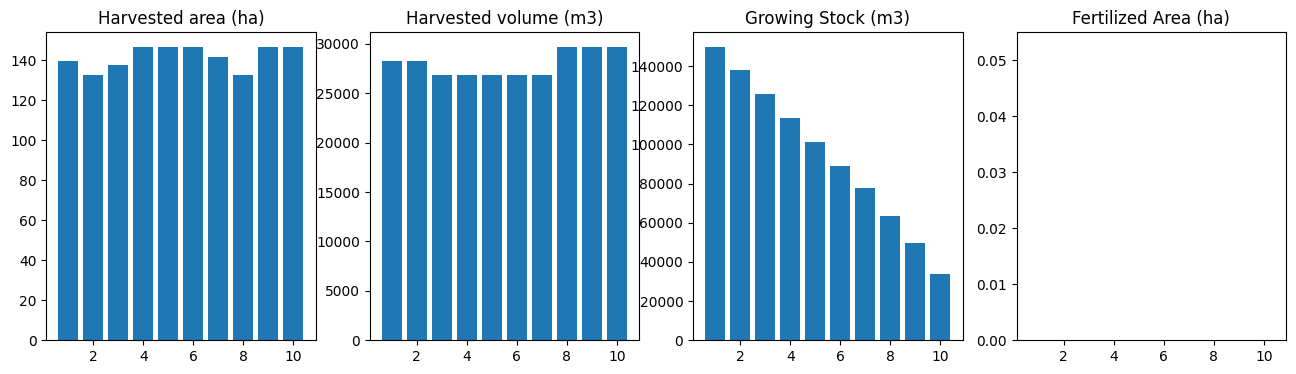

In [32]:
fig, ax = plot_scenario(df)